# Machine Learning Demonstrations

In this notebook, we showcase how to use kdb+/q to carry out machine learning tasks. Below we show how to fit a time series data set on a variety of time series models along with creating features from a time series dataset in order for it to be passed to a machine learning model.

<div class="alert alert-danger">
To run the below notebook, ensure that dependencies specified in <b>requirements.txt</b> have been correctly installed.
</div>

# Time Series Forecasting

In time series analysis, time series forecasting is the use of a model to predict the future values of a dataset based on historical observations. Forecasting can be achieved using a wide range of techniques from simple linear regression to complex neural network constructs. 

Use cases for time series forecasting vary from prediction of weather patterns to forecasting future product sales and applications in the stock market.

This notebook will demonstrate the following time series models contained within the machine learning toolkit:

- **AutoRegressive (AR) Models** 
- **AutoRegressive Integrated Moving Average (ARIMA) Models**
- **Seasonal AutoRegressive Integrated Moving Average (SARIMA) Models**

Each of these models will be explained in more detail below.

Along with these models, time series specific feature engineering tools will also be demonstrated to create lagged and windowed features.

## Machine Learning Toolkit

The ML-Toolkit contains general use utilities, an implementation of the FRESH (Feature Extraction based on Scalable Hypothesis tests) algorithm, cross validation functions and clustering algorithms. The primary purpose of these libraries are to provide kdb+/q users with access to commonly-used ML functions for preprocessing data, extracting features and scoring results.

The toolkit is used throughout this notebook and can be loaded using the below syntax.

In [1]:
\l ml/ml.q
.ml.loadfile`:init.q
\l ../utils/util.q
\l ../utils/graphics.q

## Sections

This notebook is split into 3 distinct sections:

1. [Exploring Time Series Data](#Exploring-Time-Series-Data):
    - [Autocorrelation](#Autocorrelation)
    - [Partial Autocorrelation](#Partial-Autocorrelation)
    - [Stationality](#Stationality)


2. [Models](#Models):
    - [AR](#AR-Model)
    - [ARIMA](#ARIMA-Model)
    - [SARIMA](#SARIMA-Model)


3. [Feature Engineering](#Feature-Engineering):
    - [Lagged Features](#Lagged-Features)
    - [Windowed Features](#Windowed-Features)

---

# Load and prepare the data

The dataset is provided by Transport For London (TFL) detailing the bike sales per hour in London. Additional data is given in the form of seasonality and climate information such as holiday, weather code, temperature, wind speed, current weather etc.

For the purpose of this notebook, when future predictions are being made it is assumed that the additional climate information will be available based on future weather predictions. 

In [2]:
// Load in the dataset
5#bikeSales:("PFFFFFFBFF";enlist ",")0:`:../data/london_merged.csv

timestamp                     cnt t1  t2  hum  wind_speed weather_code is_hol..
-----------------------------------------------------------------------------..
2015.01.04D00:00:00.000000000 182 3   2   93   6          3            0     ..
2015.01.04D01:00:00.000000000 138 3   2.5 93   5          1            0     ..
2015.01.04D02:00:00.000000000 134 2.5 2.5 96.5 0          1            0     ..
2015.01.04D03:00:00.000000000 72  2   2   100  0          1            0     ..
2015.01.04D04:00:00.000000000 47  2   0   93   6.5        1            0     ..


The data is plotted below to illustrate the trends and cycles present in the dataset based on a single week (168 rows).

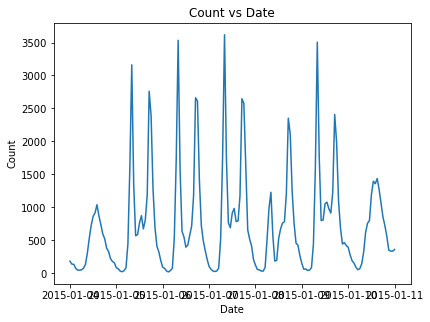

In [3]:
pltTimeSeries[168#bikeSales`timestamp;168#bikeSales`cnt;"Count"]

The below models do not account for missing timestamps, these values must be added and then back/forward filled to ensure that the data is equispaced.

The timestamp components of the time series dataset (hour, date, month etc.) is also extracted using the `.ml.timesplit` function contained within the ML toolkit.

In [4]:
// Include any missing days
bikeSales:dateFill[`timestamp;bikeSales;01:00:00.000]

// Back and forward fill data
bikeSales:.ml.filltab[bikeSales;();`timestamp;::]

// Timestamp component is broken into its constituent parts
bikeSales:.ml.timesplit[bikeSales;`timestamp] 

-1"\nThe newly created timestamp columns include:\n";
string -9#cols bikeSales

// Remove any constant columns
bikeSales:.ml.dropconstant bikeSales

// Delete any null_ cols - too many 0 values for model to preform well
delcols:cb where(cb:cols bikeSales)like"*_null"
bikeSales:![bikeSales;();0b;delcols]


The newly created timestamp columns include:



"timestamp_dow"
"timestamp_year"
"timestamp_mm"
"timestamp_dd"
"timestamp_qtr"
"timestamp_wd"
"timestamp_hh"
"timestamp_uu"
"timestamp_ss"


When splitting time series data into training and testing sets, it is important to ensure that no time leakage occurs. This means that the data must not be shuffled and the most recent data must be placed within the testing set.

In the below example, the data is split such that 80% resides in the training set, with the remaining 20% is assigned to the testing set. The additional exogenous variables are found within `xTrainSales` and `xTestSales`, while the endogenous time series data is found under `yTrainSales` and `yTestSales`.

In [8]:
// Split the data into train/test sets
tts:ttsTimeSeries[delete cnt from bikeSales;bikeSales`cnt;0.2]

xTrainSales:tts`xtrain
yTrainSales:tts`ytrain
xTestSales:tts`xtest
yTestSales:tts`ytest

-1"There are ",string[count xTrainSales]," data points in the training set";
-1"There are ",string[count xTestSales]," data points in the testing set";

There are 14035 data points in the training set
There are 3509 data points in the testing set


---

<a id='Exploring Time Series Data'></a>
# Exploring Time Series Data

Before applying a forecasting model to a time series, it is important to investigate the trends that are present in the data to be able to choose suitable input parameters for the models.

This includes looking at the Autocorrelation/Partial Autocorrelation plots and the stationality of the time series.

Autocorrelation and Partial Autocorrelation plots can be an indicator of what `p` and `q` values to apply when implementing time series models.

## Autocorrelation

Autocorrelation calculates the relationship between a current time series with its historical values.

In the below plot, the x axis provides the lag number, while the y axis represents the correlation coefficient. The red dotted line indicates the 95% confidence interval where any value above this interval is deemed to be significant.

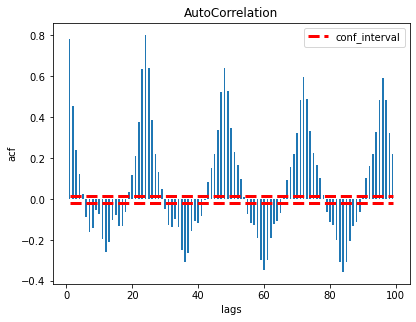

In [9]:
.ml.ts.acfPlot[yTrainSales;100]

The above plot demonstrates the change in positive and negative correlation between the bike sales compared with the night and day time.

A closer look can be taken at the data to conclude that ~4 lagged values are significant enough to be included in the model.

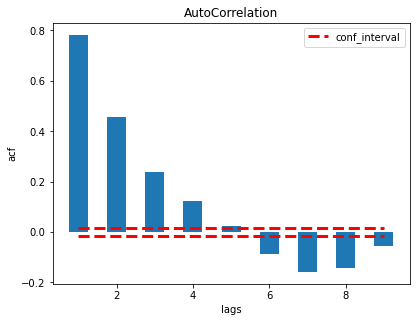

In [10]:
.ml.ts.acfPlot[yTrainSales;10]

<a id='Partial-Autocorrelation'></a>
## Partial Autocorrelation

Partial autocorrelation indicates the relationship between a time series and its historical values when correlations due to shorter lagged values are removed.

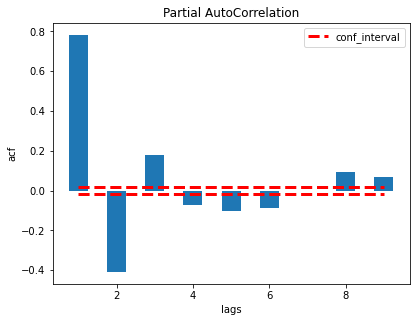

In [11]:
.ml.ts.pacfPlot[yTrainSales;10]

The above graph indicates that the first ~6 values are significant when looking at the partial autocorrelation.

#### General Features of ACF/PACF graph


ACF      |   PACF     |  Explanation
---------|------------|---------------------
Decays to 0 | Non zero values at first p points  | AR(p) model
Non zero values at first q points  | Decays to 0 | MA(q) model 
Values remain close to 1 | Values remain close to 1 | Series is non stationary 
No correlation seen | No correlation seen  | Random time series


If a model contains both AR and MA terms, the interpretation gets trickier. In general, both will taper off to 0. There may still be spikes in the ACF and/or PACF which could lead you to try AR and MA terms of that quantity. However, it usually helps to try a few different models, and based on model diagnostics, choose which one fits best.

## Stationality

Stationary time series properties remain constant over time. These include features such as mean variance, autocorrelation etc.

A time series must be stationary before being passed into a forecasting model. This can be achieved by applying differencing to the time series. This entails differencing a time series by its previous value. This process is repeated until the time series is stationary.

To test if a time series is stationary, the Augmented Dickey Fuller (ADF) Test can be applied. 

The ADF test is a type of unit root test which determines how strongly a time series is determined by a trend. The result is interpreted by a p-value returned from the tests. If the p value is <0.05 then the null hypothesis is rejected and the time series is considered to be stationary.

This can be tested using `.ml.ts.stationality`, demonstrated below.

In [13]:
.ml.ts.stationarity bikeSales`cnt

    | ADFstat   pvalue       stationary CriticalValue_1% CriticalValue_5% Cri..
----| -----------------------------------------------------------------------..
data| -9.606615 1.85885e-016 1          -3.430724        -2.861705        -2...


The function returns the p value calculated by the ADF test, along with whether or not the time series is considered to be stationary. The critical values for the test statistic at the 1 %, 5 %, and 10 % levels are also returned.

---

# Models

<a id='AR-Model'></a>
## AR Model

An AR model is a form of time series modelling where the output values of the model depend linearly on previous values in the series and a stochastic term. This model is suitable for use cases where there is a correlation between values in the past and future behaviour of the system. An AR model uses p historical lag values to calculate future values.

The equation for an AR model is given by:

$$y_t= \mu  + \sum_{i=1}^{p} \phi_{i} y_{t-i}$$

Where:

  - $y_t$ is the value of the time series at time t
  - $y_{t-i}$ is the value of the time series at time t-i
  - $\mu$ is the trend value
  - $\phi_{i}$ is the lag parameter at time t-i

### Fitting an AR model

### Inputs

The inputs to `.ml.ts.AR.fit` are:

Parameter      |  Explanation
---------------|---------------------------
endog          | The endogenous variable (predicted y value) (list)
exog          | Exogenous variables (table)
p            | Number of lag observations in the model (int)
tr        | Add trend value (boolean)

### Returns

The model returns a dictionary with the following information

key        |  Explanation
-----------|---------------------------
params     | model parameters for future predictions
tr_param   | trend parameters
exog_param | exog parameters
p_param    | lag value parameters
lags       | lagged values from the training set

In the results obtained from the ACF plot, the first 4 lagged values will be used for forecasting future values.

In [14]:
start:.z.t
show ARmdl:.ml.ts.AR.fit[yTrainSales;xTrainSales;4;1b]
ARtime:string .z.t-start
-1"\nTime taken for AR model to run: ",ARtime;

params    | -32158.33 40.73459 -13.06289 -11.05007 -3.961623 -6.31718 -52.838..
tr_param  | ,-32158.33
exog_param| 40.73459 -13.06289 -11.05007 -3.961623 -6.31718 -52.83868 9.69335..
p_param   | -0.1814609 0.239931 -0.6573242 1.060154
lags      | 1763 2492 4505 4379f

Time taken for AR model to run: 00:00:00.060


### Predicting future values using an AR model

### Inputs

The inputs to `.ml.ts.AR.predict` are 


Parameter      |  Explanation
---------------|---------------------------
mdl          | Model generated by .ml.ts.AR.fit
exog          | Exogenous variables (table)
steps          | How many steps in the future to forecast

The function returns the predicted values.

Future values are forecasted using a previously built AR model.

The root mean squared error between the predicted and true values is then calculated.

In [15]:
show ARpred:.ml.ts.AR.predict[ARmdl;xTestSales;count yTestSales]

// Calculate the error
-1!"The RMSLE is ",string .ml.rmsle[ARpred;yTestSales]

3202.51 2407.949 1881.177 1558.172 1567.3 1388.267 1141.637 968.8153 864.634 ..


"The RMSLE is 1.008865"


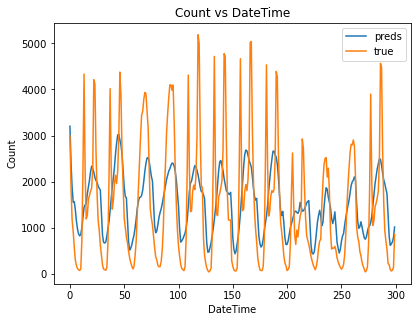

In [16]:
pltResult[300#ARpred;300#yTestSales;"Count"]

When future values are calculated solely by regressing on historical information, the model captures the overall trend of the time series. However, it does not accurately predict the height and depth of each peak and trough present.

## ARIMA Model

An ARMA model can be used to describe any weakly stationary stochastic time series in terms of two polynomials, the first of these is for autoregression based on p lag values, the second for the moving average based on q past residual errors.

An ARIMA model is an extension of the ARMA model. As with the ARMA model, this takes into account lagged values and past residual errors when generating the model and predictions. The integrated aspect of the model is the result of differencing the time series d times in order to generate a 'stationary' time series. Once differenced and stationary, an ARMA model can be generated and applied to forecast future values.

The equation for an ARIMA model is given by

$$\widehat{y}_{t}= \mu  + \sum_{i=1}^{p} \phi_{i} y_{t-i} + \sum_{i=1}^{q} \theta_{i} \epsilon_{t-i}$$

Where:

  - $\widehat{y}_{t}$ is the differenced time series at time t
  - $\mu$ is the trend value
  - $p$ is the order of lagged values to be accounted for in model generation
  - $q$ is the order of residual errors to be accounted for in model generation
  - $y_{t-i}$ is the value of the time series at time t-i
  - $\phi_{i}$ is the lag parameter at time t-i
  - $\epsilon_{t-i}$ is the residual error term at time t-i
  - $\theta_{i}$ is the residual error parameter at time t-i



### Fitting an ARIMA model

### Inputs

The inputs to `.ml.ts.ARIMA.fit` are:

Parameter      |  Explanation
---------------|---------------------------
endog          | The endogenous variable (predicted y value) (list)
exog          | Exogenous variables (table)
p            | Number of lag observations in the model (int)
d            | Number of times that the observations are differenced (int)
q          | Size of moving average window (int)
tr        | Add trend value (boolean)

The Hannan-Rissanen algorithm will be used to estimate the residual errors. This method includes:
- Using a high order AR model (using least square methods) in order make estimates and calculate the residual errors. 
- Ordinary least squares (OLS) is then used to estimate the lag (p) and residual error (q) coefficients along with any trend present or exogenous column.

### Returns

The model returns a dictionary with the following information:

key         |  Explanation
------------|---------------------------
params      | model parameters for future predictions
tr_param    | trend parameters
exog_param  | exog parameters
p_param     | lag value paraeaters
q_param     | error parameters
lags        | lagged values from the training set
resid       | q residual errors calculated from training set using the params
estresid    | coefficients used to estimate resid errors
origs       | original values to be used to transform seasonal differencing to original format
pred_dict   | a dictionary containing information about the model used for fitting

As the model is stationary, no differencing is needed for this dataset, but a Moving Average term of 1 will be applied along with a `p` value of 6.

In [17]:
start:.z.t
show ARIMAmdl:.ml.ts.ARIMA.fit[yTrainSales;xTrainSales;6;0;1;1b]
ARIMAtime:string .z.t-start
-1"\nTime taken for ARIMA model to run: ",ARIMAtime;

params    | -39242.39 38.04685 -11.06275 -9.762868 -4.662471 -7.278939 -82.26..
tr_param  | -39242.39
exog_param| 38.04685 -11.06275 -9.762868 -4.662471 -7.278939 -82.26773 3.7471..
p_param   | -0.09884499 -0.05151528 -0.0792753 0.2723364 -0.8428459 1.241551
q_param   | ,-0.2397018
lags      | 1510 1584 1602 1763 2492 4505 4379f
resid     | ,-55.26887
estresid  | 47.97336 -13.98663 -12.12876 -5.696232 -7.94385 -103.3163 3.96534..
pred_dict | `p`q`tr!(6;1;1b)
origd     | `float$()

Time taken for ARIMA model to run: 00:00:00.994


### Predicting future values using an ARIMA model

### Inputs

The inputs to `.ml.ts.ARIMA.predict` are 

Parameter      |  Explanation
---------------|---------------------------
mdl          | Model generated by .ml.ts.AR.fit
exog          | Exogenous variables (table)
steps          | How many steps in the future to forecast

The function returns the predicted values.

Future values are forecasted using a previously built ARIMA model.

The root mean squared error between the predicted and true values is then calculated.

In [18]:
show ARIMApred:.ml.ts.ARIMA.predict[ARIMAmdl;xTestSales;count yTestSales]

// Calculate the error
-1!"The RMSLE is ",string .ml.rmsle[ARIMApred;yTestSales]

3200.623 2330.229 1939.453 1677.643 1337.051 734.4333 308.7661 261.2954 442.6..


"The RMSLE is 0.901618"


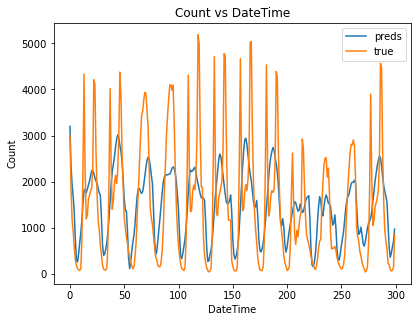

In [19]:
pltResult[300#ARIMApred;300#yTestSales;"Count"]

Including the moving average terms when forecasting the future values reduce the error score for the model. Again, the trend is captured but it still does not accurately estimate the height of the daily peaks obtained.

### Akiake Information Criteria (AIC)

The AIC score can be used when choosing the optimal input parameters to implement for an ARIMA model. The AIC is commonly used to measure a statistical model by taking into account the goodness of fit and the simplicity of the model. The lower the score signifies a better model. 

The formula is:

`AIC = -2log(L) + 2(k+1)`

Where `L` is the likelihood of the data (How well it preforms) and `k` is the sum of the parameters used.

#### Inputs

The inputs to `.ml.ts.ARIMA.aicParam` are

Parameter      |  Explanation
---------------|---------------------------
train          | training data dictionary with keys ``` `endog`exog ```
test           | testing data dictionary with keys ``` `endog`exog ```
len            | the number of values that are to be predicted
dict           | dictionary of different input parameters to score

In [20]:
// Set up a training and test dictionary 
trainDict:`endog`exog!(yTrainSales;xTrainSales)
testDict:`endog`exog!(yTestSales;xTestSales)

// Set a list of input parameters to test
show param:`p`d`q`tr!(1 3 4 6;0 0 0 0;1 3 4 1;1111b)

p | 1 3 4 6
d | 0 0 0 0
q | 1 3 4 1
tr| 1 1 1 1


The training and testing dictionary is passed to the model along with the variety of input parameters to test.

The model returns the parameters with the lowest AIC score.

In [21]:
.ml.ts.ARIMA.aicParam[trainDict;testDict;count xTestSales;param]

p    | 6
d    | 0
q    | 1
tr   | 1b
score| 47922.26


## SARIMA Model

A SARIMA model is an extension of the ARIMA model described above. As noted previously, ARIMA models cannot be used in cases where there is cyclical variability in the behaviour of the time series.

Similar to the ARIMA model which accounts for historical lag components `p`, residual errors `q` and a set of time series differencing `d`, the seasonal component of a SARIMA model has equivalent components.

* `P` is the autoregressive lag term of the seasonal component of the model
* `Q` is the residual moving average term of the seasonal component model
* `D` is the seasonal differencing term of the model

SARIMA models are usually denoted by the following definition

$$ARIMA(p,d,q)(P,D,Q)_{m}$$

where the upper case components are defined above and $m$ refers to the number of periods in each season.

A further outline of SARIMA model generation and use can be found [here](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html#ARIMA-Example-3:-Airline-Model).



### Fitting a SARIMA model

### Inputs

The inputs to `.ml.ts.SARIMA.fit` are:

Parameter      |  Explanation
---------------|---------------------------
endog          | The endogenous variable (predicted y value) (list)
exog          | Exogenous variables (table)
p            | Number of lag observations in the model (int)
d            | Number of times that the observations are differenced (int)
q          | Size of moving average window (int)
tr        | Add trend value (boolean)
s        | Dictionary with seasonal P,D,Q and m(periodicy) values


The `Broyden-Fletcher-Goldfarb-Shanno` algorithm will be used in order to optimize the parameters of this model

### Returns

The model returns a dictionary with the following information

key         |  Explanation
------------|---------------------------
params      | model parameters for future predictions
tr_param    | trend parameters
exog_param  | exog parameters
p_param     | lag value parameters
q_param     | error parameters
P_param     | seasonal lag value parameters
Q_param     | seasonal error parameters
lags        | lagged values from the training set
resid       | q residual errors calculated from training set using the params
estresid    | coefficients used to estimate resid errors
origd       | original values of input values before being differentiated
origs       | original values to be used to transform seasonal differencing to original format
pred_dict   | a dictionary containing information about the model used for fitting

As the data is hourly, there is a variety of seasonality periods that can be used such as `daily` (24 rows) or `weekly` (168 rows).

In this case a weekly period was chosen.

In [22]:
// Create the seasonal dictionary
show s:`P`D`Q`m!1 1 0 168

P| 1
D| 1
Q| 0
m| 168


In [23]:
start:.z.t
show SARIMAmdl:.ml.ts.SARIMA.fit[yTrainSales;xTrainSales;4;0;2;1b;s]
SARIMAtime:string .z.t-start
-1"\nTime taken for SARIMA model to run: ",SARIMAtime;

params    | -16602.21 3.101582 -0.8650241 -0.05566507 0.1070878 -13.20119 58...
tr_param  | -16602.21
exog_param| 3.101582 -0.8650241 -0.05566507 0.1070878 -13.20119 58.09407 0.14..
p_param   | -0.06948672 0.3472193 -0.8746816 1.410398
q_param   | 0.1393786 -0.3684515
P_param   | ,-0.4355237
Q_param   | `float$()
lags      | 158 211 282 536 690 273 9 -19 49 -92 -49 -38 -30 -26 -26 -42 -120..
resid     | -62.29258 -60.18051 -162.339 -309.8758
estresid  | 2.181841 -0.742912 -1.923207 -1.59838 -10.99316 35.60639 9.614309..
pred_dict | `p`q`P`Q`m`tr`seas_add_P`seas_add_Q`n!(4;2;,0;`long$();168;1b;1 2..
origd     | `float$()
origs     | 3029 1911 1280 975 697 308 176 119 54 56 148 759 2319 4614 2415 1..

Time taken for SARIMA model to run: 00:00:07.665


### Predicting future values using an AR model

### Inputs

The inputs to `.ml.ts.SARIMA.predict` are 

Parameter      |  Explanation
---------------|---------------------------
mdl          | Model generated by .ml.ts.AR.fit
exog          | Exogenous variables (table)
steps          | How many steps in the future to forecast

The function returns the predicted values.

Future values are forecasted using a previously built SARIMA model.

The root mean squared error between the predicted and true values is then calculated.

In [24]:
show SARIMApred:.ml.ts.SARIMA.predict[SARIMAmdl;xTestSales;count yTestSales]

// Calculate the error
-1!"The RMSLE is ",string .ml.rmsle[SARIMApred;yTestSales]

2766.088 1765.194 1273.545 1075.232 655.3774 167.4672 55.0135 38.47451 -111.9..


"The RMSLE is 0.8491875"


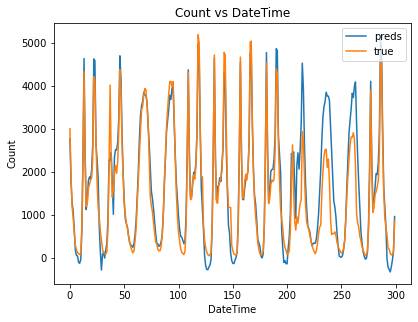

In [25]:
pltResult[300#SARIMApred;300#yTestSales;"Count"]

Including the seasonal terms in a model allows for both the overall trend of the time series along with a better estimate of the height and depths of the peaks and trough values to be calculated.

---

<a id='Feature-Engineering'></a>
# Feature Engineering

Feature extraction can be applied to time series data, extracting lagged and windowed features to make the model more suitable to be passed into a traditional supervised machine learning model.

When deciding what lagged and window lengths to use, it is also worth noting that the larger the value that you use, the less data that is available for training. For example, if a lagged period of `N` is chosen, then the first `N` rows will have to be removed as the features are null.

## Lagged Features

Knowing how a given time series performed in the past can be an important feature used when forecasting future behaviour. 

In the above `bikeSales` dataset, including past sales up to 7 days (168 rows) prior to the event is used to forecast the future values.

The input values to `.ml.ts.laggedFeatures` are:

Parameter.      |  Explanation
----------------|--------------------------
tab             | is a table containing equispaced time series data
colNames        | is a list of columns to extract the lag values from
lags            | is a list of historic lags to be added as columns to the dataset

The first 168 rows of the newly created table contain null values as the previous lagged values up to this point are not present.

In [26]:
5#laggedTab:.ml.ts.laggedFeatures[bikeSales;enlist`cnt;1 2 24 168]

// Show the new lagged columns created
5#reverse each laggedTab

cnt t1  t2  hum  wind_speed weather_code is_weekend season timestamp_dow time..
-----------------------------------------------------------------------------..
182 3   2   93   6          3            1          3      1             2015..
138 3   2.5 93   5          1            1          3      1             2015..
134 2.5 2.5 96.5 0          1            1          3      1             2015..
72  2   2   100  0          1            1          3      1             2015..
47  2   0   93   6.5        1            1          3      1             2015..


cnt_xprev_168 cnt_xprev_24 cnt_xprev_2 cnt_xprev_1 timestamp_hh timestamp_wd ..
-----------------------------------------------------------------------------..
                                                   0            0            ..
                                       182         1            0            ..
                           182         138         2            0            ..
                           138         134         3            0            ..
                           134         72          4            0            ..


## Windowed Features

Investigating how the model acts in varying window sizes prior to the event is also another tool used for feature engineering in time series modelling. This includes applying functions such as the `max`, `min` `avg` etc over different window sizes. 

Including how these values changes over periods of time up to 7 days (168 rows) prior to the event are investigated below.

The input values to `.ml.ts.windowFeatures` are:

Parameter.      |  Explanation
----------------|--------------------------
tab             | is a table containing equispaced time series data
colNames        | is a list of columns to extract the lag values from
funcs           |list of function names (as symbols) which are to be applied to the time series
wins            |list of window sizes on which to apply these functions

The first 168 rows of the dataset are removed as these are produced with insufficient data to provide accurate results.

In [27]:
// Create the windowed features
5#windowLagTab:.ml.ts.windowFeatures[laggedTab;enlist`cnt;`min`max`avg`dev;2 24 168]

// Show the new windowed columns created
5#reverse each windowLagTab

cnt t1  t2   hum  wind_speed weather_code is_weekend season timestamp_dow tim..
-----------------------------------------------------------------------------..
360 4.5 0.5  72.5 22         1            1          3      1             201..
255 4   -0.5 75   22         1            1          3      1             201..
198 4   -0.5 75   23         1            1          3      1             201..
135 4   -1   75   27         2            1          3      1             201..
74  4   -1   72.5 28         1            1          3      1             201..


dev_168_cnt dev_24_cnt dev_2_cnt avg_168_cnt avg_24_cnt avg_2_cnt max_168_cnt..
-----------------------------------------------------------------------------..
772.6513    451.7794   0.5       751.6429    612.875    334.5     3618       ..
771.9912    452.476    13        752.7024    611.5417   347       3618       ..
771.489     453.1745   52.5      753.3988    610.625    307.5     3618       ..
771.1988    452.8291   28.5      753.7798    611        226.5     3618       ..
770.8824    453.6013   31.5      754.1548    610.25     166.5     3618       ..


### RandomForest Regressor

The newly created table `windowLagTab` is split into a training and testing set to be passed into a supervised Random Forest Regressor Model.

In [28]:
// Split the data into train/test sets
tts:ttsTimeSeries[delete cnt from windowLagTab;exec cnt from windowLagTab;0.2]

xTrainFeat:tts`xtrain
yTrainFeat:tts`ytrain
xTestFeat:tts`xtest
yTestFeat:tts`ytest

-1!"There is ",string[count xTrainFeat]," data points in the training set"
-1!"There is ",string[count xTestFeat]," data points in the testing set"

"There is 13900 data points in the training set"


"There is 3476 data points in the testing set"


The testing data is fit to a vanilla Random Forest Regressor model

In [29]:
// Load in the Gradient Boost Regressor
randomForest:.p.import[`sklearn.ensemble]`:RandomForestRegressor;

// Set the random state to 0
randomForestMdl:randomForest[`random_state pykw 0];

start:.z.t
// Fit the model to the training data
randomForestMdl[`:fit][flip value flip xTrainFeat;yTrainFeat];
RFtime:string .z.t-start
-1"\nTime taken for RandomForest to run: ",RFtime;


Time taken for RandomForest to run: 00:00:23.675


The fitted model is then used to predict the future values of the time series and the root mean squared error is obtained.

In [30]:
show predsFeat:randomForestMdl[`:predict][flip value flip xTestFeat]`

-1!"The RMSLE is ",string .ml.rmsle[predsFeat;yTestFeat]

72.21 143.51 676.37 2126.97 3709.2 2244.44 1301.22 1377.49 1810.09 2134.79 22..


"The RMSLE is 0.2452899"


The predicted values are plotted against the true values.

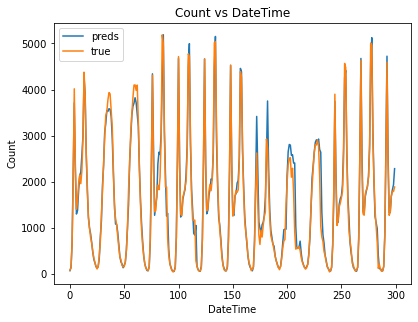

In [31]:
pltResult[300#predsFeat;300#yTestFeat;"Count"]

The above plotted results graph shows that including lagged and windowed features when forecasting future values using a supervised machine learning model can predict results with low error.

---